In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import simps

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path_prefix = '/content/drive/Shared drives/CS 230 Project (EEG)/'
#data = np.load(path_prefix + 's44_data.npy')
#labels = np.load(path_prefix + 's44_labels.npy')

data = np.load(path_prefix + 'combined_subjects_data.npy')
labels = np.load(path_prefix + 'combined_subjects_labels.npy')

In [5]:
print(np.shape(data))

(26065, 30, 500)


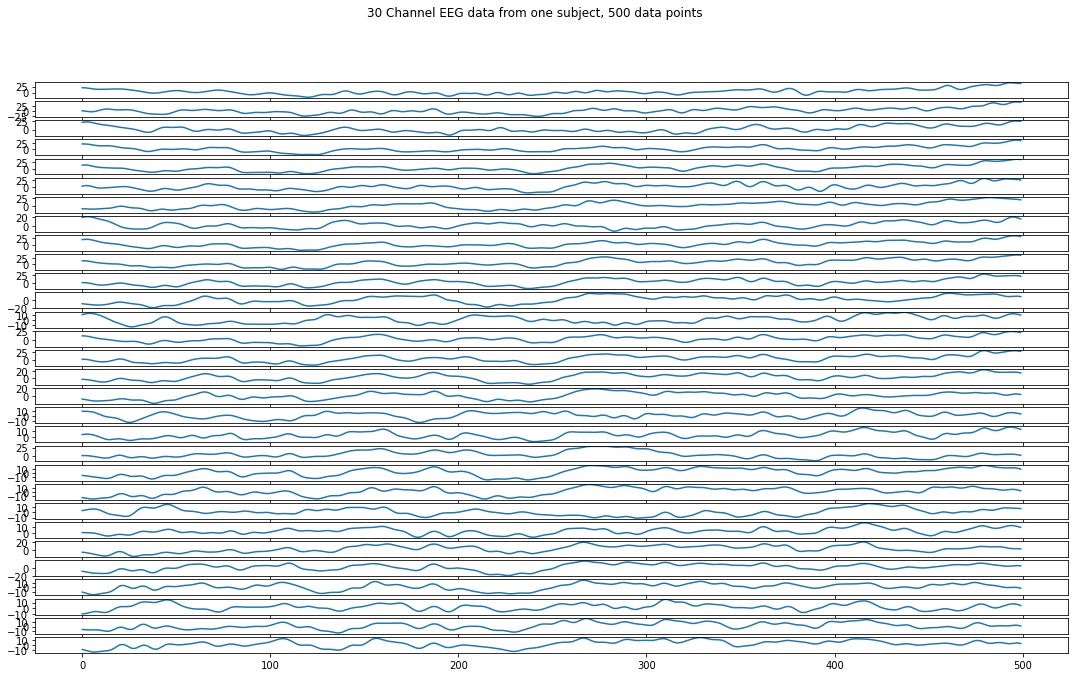

In [0]:
fig, axs = plt.subplots(30)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('30 Channel EEG data from one subject, 500 data points')
for i in range(data.shape[1]):
    axs[i].plot(data[0, i, :])

In [0]:
print(np.shape(data))

(2309, 30, 500)


(0.0, 30.0)

<Figure size 432x288 with 0 Axes>

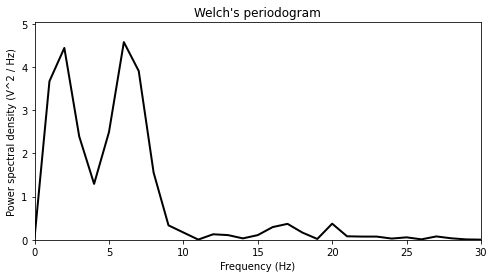

In [6]:
#Set window length and sampling frequency
sf = 500
win = 1 * sf
freqs, psd = signal.welch(data[0][0], sf, nperseg=win)

fig = plt.figure()
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 30])

In [0]:
# Define delta lower and upper limits
low, high = 1, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Frequency resolution
freq_res = freqs[1] - freqs[0]
print(freq_res)

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

1.0
Absolute delta power: 14.716 uV^2
Relative delta power: 0.197


In [0]:
def bandpower(data, sf, bands, method='multitaper', window_sec=None, relative=False, band_power_mode=True):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    bps = []
    for band in bands:
      band = np.asarray(band)
      low, high = band

      # Compute the modified periodogram (Welch)
      if method == 'welch':
          if window_sec is not None:
              nperseg = window_sec * sf
          else:
              nperseg = (2 / low) * sf

          freqs, psd = welch(data, sf, nperseg=nperseg)

      elif method == 'multitaper':
          psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)

      # Frequency resolution
      freq_res = freqs[1] - freqs[0]

      # Find index of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)
      bp = simps(psd[idx_band], dx=freq_res)
      bps.append(bp)
    
    return bps/simps(psd, dx=freq_res)

    '''if band_power_mode:
      # Integral approximation of the spectrum using parabola (Simpson's rule)
      bp = simps(psd[idx_band], dx=freq_res)

      if relative:
          bp /= simps(psd, dx=freq_res)
      return bp
    else:
      return psd[idx_band]'''

In [8]:
!pip install mne

     |████████████████████████████████| 6.6MB 3.4MB/s 


In [9]:
# Multitaper delta power
row = 1
col = 6
bp = bandpower(data[row][col], sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(data[row][col], sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data[row][col], sf, [0.5, 4], 'multitaper') / bandpower(data[row][col], sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data[row][col], sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data[row][col], sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Absolute delta power: 6.965
Relative delta power: 0.385
Delta/beta ratio (absolute): 2.885
Delta/beta ratio (relative): 2.885


In [31]:
print(np.shape(data))
for i in range(10):
  print(i)

(26065, 30, 500)
0
1
2
3
4
5
6
7
8
9


In [48]:
freq_bands = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
print(len(freq_bands))
psd_data = np.zeros((np.shape(data)[0], np.shape(data)[1], len(freq_bands)))

sf = 500

count = 0
row_start = 18000
row_end = 23000
cols = np.shape(data)[1]
total = (row_end-row_start)*cols
total = total - (total % 10)
print(total)
for i in range(row_start, row_end):
  for j in range(cols):
    bp_rel = bandpower(data[i][j], sf, freq_bands, 'multitaper', relative=True)
    psd_data[i][j] = np.array(bp_rel)
    count += 1
    if count % (total/10) == 0:
      print("Finished " + str(count/total*100) + "% of calculations")

5
150000


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 10.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 20.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 30.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 40.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 50.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 60.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 70.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 80.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 90.0% of calculations


<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-17-3908fc267eb8>:48: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 100.0% of calculations


In [46]:
print(psd_data[9999])

[[0.25419112 0.16954629 0.22750495 0.24504044 0.02758617]
 [0.17464379 0.20530515 0.2605069  0.28169071 0.02730499]
 [0.22265262 0.19118128 0.24956789 0.24717006 0.02233089]
 [0.06948487 0.20731657 0.33105705 0.35171342 0.02147319]
 [0.08922001 0.22914445 0.32819965 0.31382542 0.02432347]
 [0.08886765 0.22584821 0.31997098 0.30189635 0.04540011]
 [0.13612219 0.20981457 0.3102794  0.28433543 0.02384978]
 [0.10175968 0.21069797 0.29794876 0.33262962 0.0275954 ]
 [0.08254903 0.21155791 0.3099845  0.34145077 0.03377961]
 [0.07589431 0.26426099 0.34087591 0.2785137  0.02908981]
 [0.11528013 0.25052826 0.30928625 0.25940762 0.04366013]
 [0.10012557 0.23930797 0.32974068 0.27677745 0.02196871]
 [0.15107074 0.19330327 0.27882987 0.28746131 0.04431028]
 [0.09066739 0.21563188 0.29423734 0.34662004 0.03447441]
 [0.08093832 0.25515663 0.35587797 0.26674097 0.03239774]
 [0.0788282  0.27140169 0.34404448 0.26665456 0.03786025]
 [0.17420387 0.22579146 0.28162691 0.23755042 0.01646953]
 [0.15605109 0

In [0]:
#freq_bands = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
freq_bands = [[0.5, 30]]
print(len(freq_bands))
psd_data = np.zeros((np.shape(data)[0], np.shape(data)[1], 30))

sf = 500

count = 0
rows = np.shape(data)[0]
cols = np.shape(data)[1]
total = rows*cols*len(freq_bands)
total = total - (total % 10)
print(total)
for i in range(rows):
  for j in range(cols):
    for k in range(len(freq_bands)):
      bp_rel = bandpower(data[i][j], sf, freq_bands[k], 'welch', relative=True, band_power_mode=False)
      #print(bp_rel.shape)
      psd_data[i][j] = bp_rel
      count += 1
      if count % (total/10) == 0:
        print("Finished " + str(count/total*100) + "% of calculations")

1
69270


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


Finished 10.0% of calculations
Finished 20.0% of calculations
Finished 30.0% of calculations
Finished 40.0% of calculations
Finished 50.0% of calculations
Finished 60.0% of calculations
Finished 70.0% of calculations
Finished 80.0% of calculations
Finished 90.0% of calculations
Finished 100.0% of calculations


In [0]:
np.save(path_prefix + 'combined_subjects_psd_5.npy', psd_data)

In [0]:
print(bandpower(data[0][0], sf, [8,12], 'welch', relative=True))

0.15573710116603498
